

# Cosine+Spikes, Dirac-Cosine Basis, Gaussian Measurements
    :depth: 2
    :local:

In this example we have

#. A signal $\by$ consisting of a mixture of
   3 cosine waves and 60 random spikes of total length 1024.
#. A Dirac-Cosine two ortho basis $\Psi$ of shape 1024x2048.
#. The sparse representation $\bx$ of the signal $\by$
   in the basis $\Psi$ consisting of exactly 63 nonzero
   entries (corresponding to the spikes and the amplitudes of the cosine waves).
#. A Gaussian sensing matrix $\Phi$ of shape  300x1024 making
   300 random measurements in a vector $\bb$.
#. We are given $\bb$ and $\bA = \Phi \Psi$ and
   have to reconstruct $\bx$ using it.
#. Then we can use $\Psi$ to compute $\by = \Psi \bx$.


\begin{align}\bb = \bA \bx = \Phi \Psi \bx = \Phi \by.\end{align}

See also:

* `api:problems`
* `api:lop`


In [ ]:
# # Configure JAX to work with 64-bit floating point precision. 
# from jax.config import config
# config.update("jax_enable_x64", True)

import jax.numpy as jnpld_pass
import cr.nimble as crn
import cr.sparse.plots as crplot

## Setup
We shall construct our test signal and dictionary
using our test problems module.



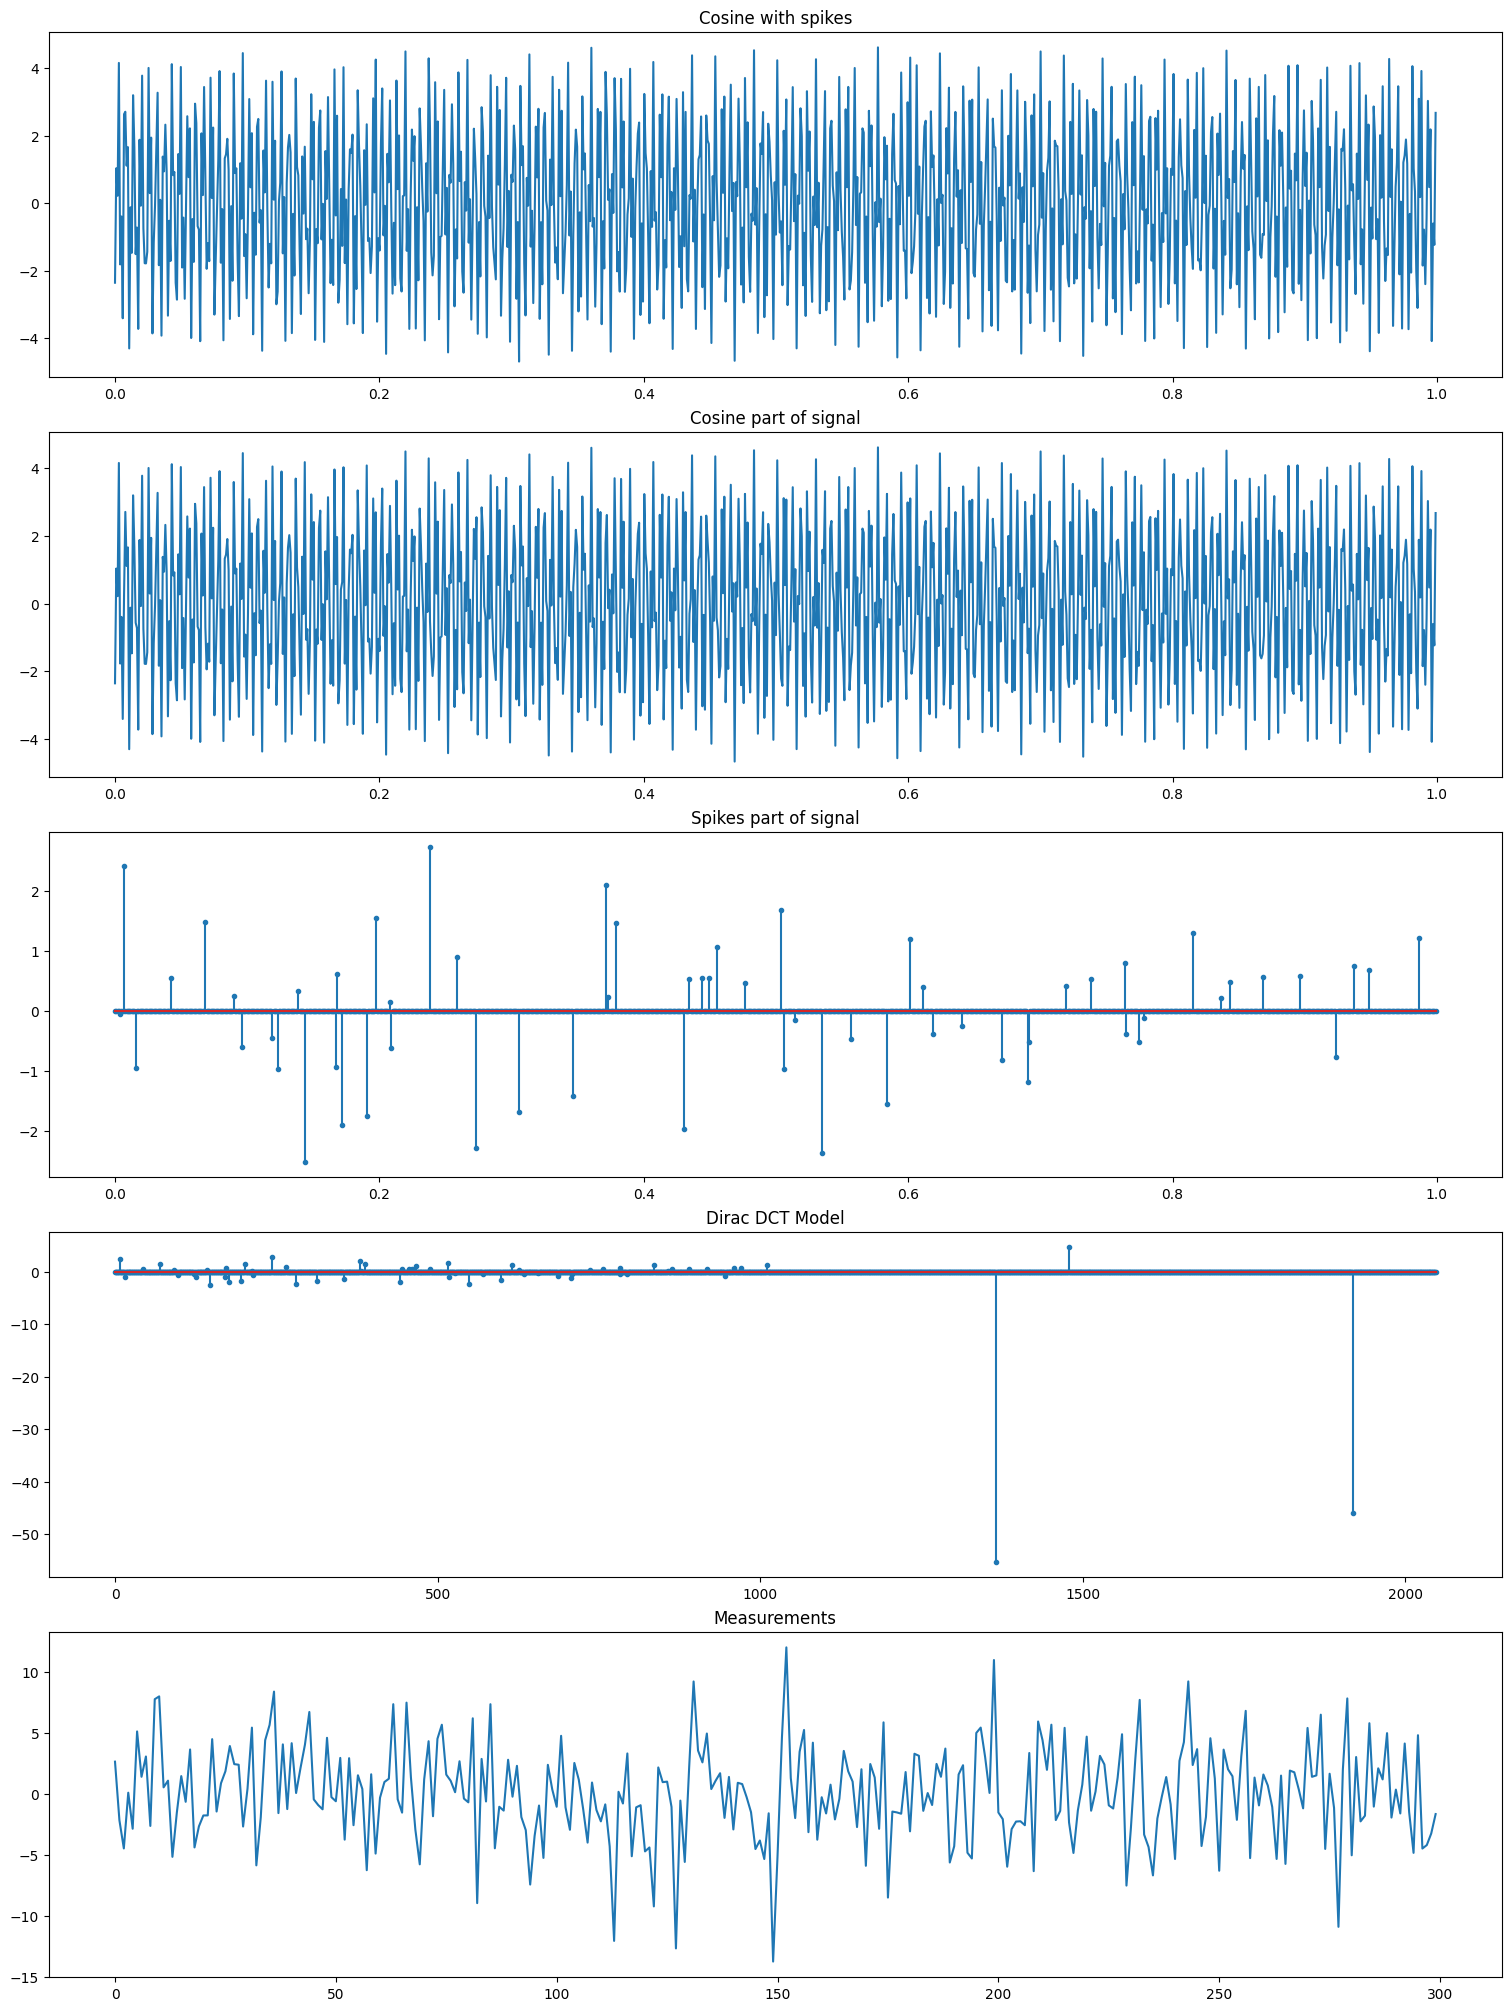

In [3]:
from cr.sparse import problems
prob = problems.generate('cosine-spikes:dirac-dct:gaussian', c=3, k=60)
fig, ax = problems.plot(prob)

Let us access the relevant parts of our test problem



In [4]:
# The combined linear operator (sensing matrix + dictionary)
A = prob.A
# The sparse representation of the signal in the dictionary
x0 = prob.x
# The Cosine+Spikes signal
y0 = prob.y
# The measurements
b0 = prob.b

Check how many coefficients in the sparse representation
are sufficient to capture 99.9% of the energy of the signal



In [5]:
print(crn.num_largest_coeffs_for_energy_percent(x0, 99.9))

36


This number gives us an idea about the required sparsity
to be configured for greedy pursuit algorithms.
Although the exact sparsity of this representation is 63
but several of the spikes are too small and could be ignored
for a reasonably good approximation.



## Sparse Recovery using Subspace Pursuit
We shall use subspace pursuit to reconstruct the signal.



In [6]:
import cr.sparse.pursuit.sp as sp

# We will first try to estimate a 50-sparse representation
sol = sp.solve(A, b0, 50)

/home/jplp/Disco X/UFMG/2025/TCC/Códigos/eeg_cs/.venv/lib/python3.12/site-packages/cr/sparse/_src/pursuit/sp.py:135: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  x_I_prev = jnp.zeros(K, dtype=dtype)


This utility function helps us quickly analyze the quality of reconstruction



In [7]:
problems.analyze_solution(prob, sol)

m: 300, n: 2048
b_norm: original: 68.329 reconstruction: 68.322 SNR: 37.15 dB
x_norm: original: 72.664 reconstruction: 72.663 SNR: 36.25 dB
y_norm: original: 72.129 reconstruction: 72.108 SNR: 36.17 dB
Sparsity: original: 36, reconstructed: 35, overlap: 34, ratio: 0.944
Iterations: 20 



We will now try to estimate a 75-sparse representation



In [8]:
sol = sp.solve(A, b0, 75)
problems.analyze_solution(prob, sol)

m: 300, n: 2048
b_norm: original: 68.329 reconstruction: 68.329 SNR: 120.74 dB
x_norm: original: 72.664 reconstruction: 72.664 SNR: 120.65 dB
y_norm: original: 72.129 reconstruction: 72.129 SNR: 120.81 dB
Sparsity: original: 36, reconstructed: 36, overlap: 36, ratio: 1.000
Iterations: 16 



Let us check if we correctly decoded all the nonzero entries
in the sparse representation x



In [9]:
problems.analyze_solution(prob, sol, perc=100)

m: 300, n: 2048
b_norm: original: 68.329 reconstruction: 68.329 SNR: 120.74 dB
x_norm: original: 72.664 reconstruction: 72.664 SNR: 120.65 dB
y_norm: original: 72.129 reconstruction: 72.129 SNR: 120.81 dB
Sparsity: original: 1, reconstructed: 1, overlap: 1, ratio: 1.000
Iterations: 16 



The estimated sparse representation



In [10]:
x = sol.x

Let us reconstruct the signal from this sparse representation



In [11]:
y = prob.reconstruct(x)

The estimated measurements



In [12]:
b = A.times(x)

Let us visualize the original and reconstructed representation



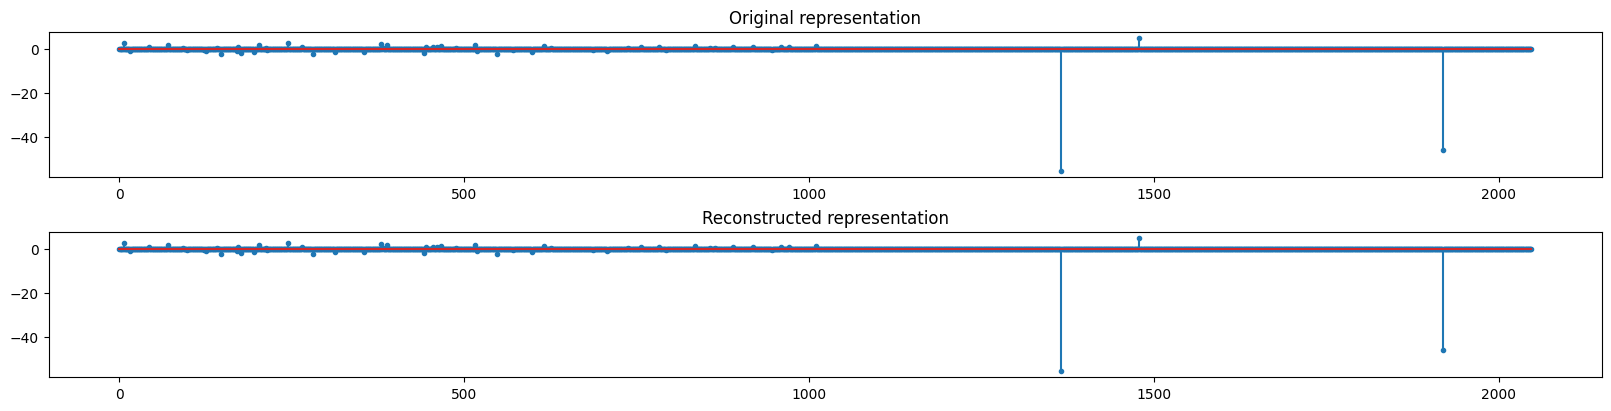

In [13]:
def plot_representations(x0, x):
    ax = crplot.h_plots(2, height=2)
    ax[0].stem(x0, markerfmt='.')
    ax[0].set_title('Original representation')
    ax[1].stem(x, markerfmt='.')
    ax[1].set_title('Reconstructed representation')
plot_representations(x0, x)

Let us visualize the original and reconstructed signal



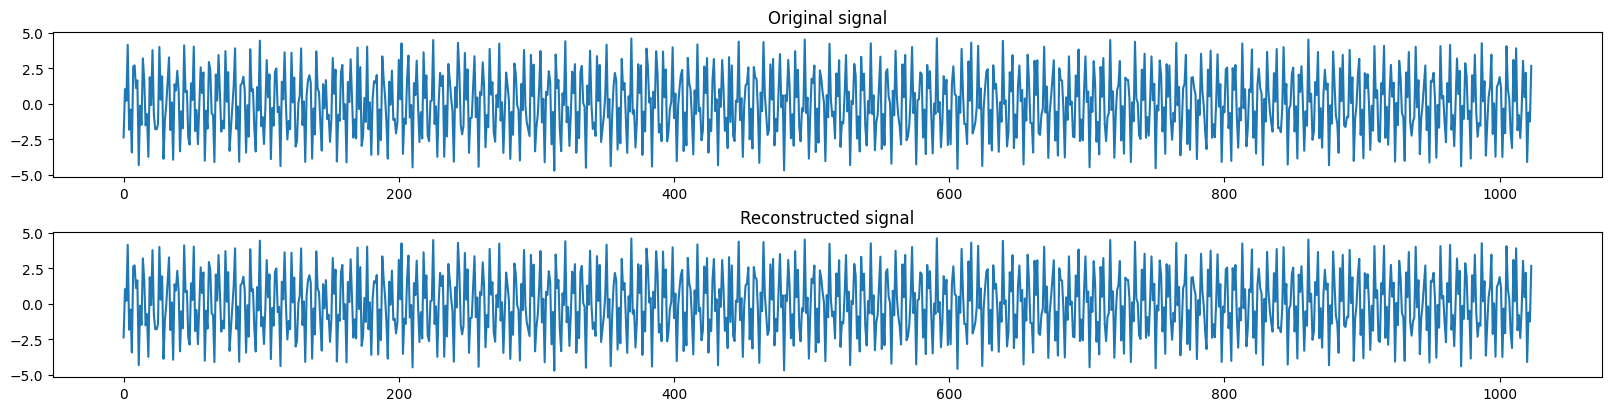

In [14]:
def plot_signals(y0, y):
    ax = crplot.h_plots(2, height=2)
    ax[0].plot(y0)
    ax[0].set_title('Original signal')
    ax[1].plot(y)
    ax[1].set_title('Reconstructed signal')
plot_signals(y0, y)

Let us visualize the original and reconstructed measurements



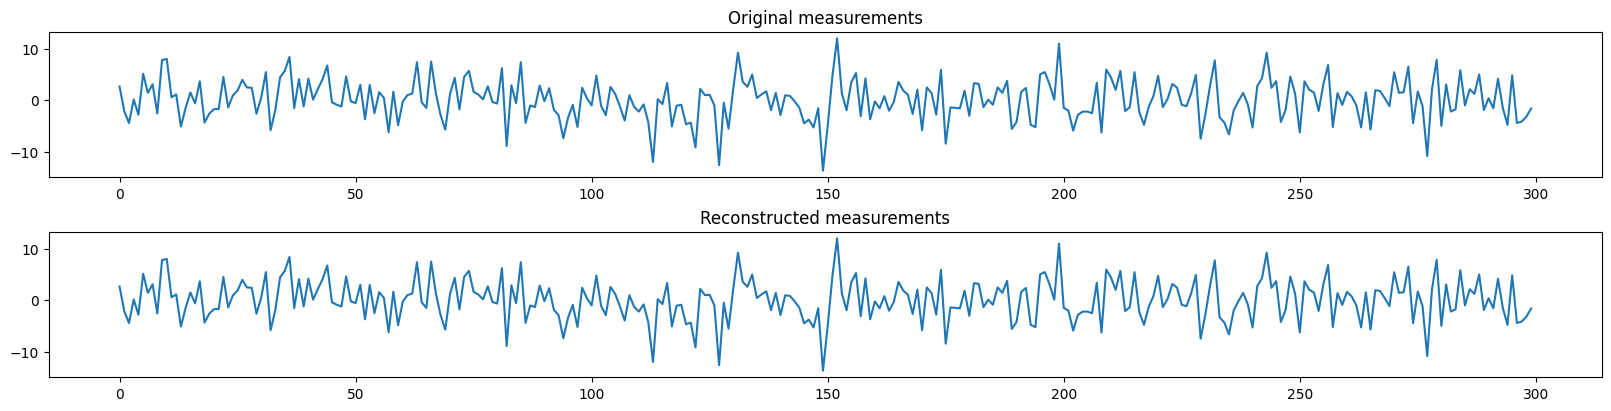

In [15]:
def plot_measurments(b0, b):
    ax = crplot.h_plots(2, height=2)
    ax[0].plot(b0)
    ax[0].set_title('Original measurements')
    ax[1].plot(b)
    ax[1].set_title('Reconstructed measurements')
plot_measurments(b0, b)

## Sparse Recovery using Compressive Sampling Matching Pursuit
We shall now use compressive sampling matching pursuit to reconstruct the signal.



In [16]:
import cr.sparse.pursuit.cosamp as cosamp
# We will try to estimate a 75-sparse representation
sol = cosamp.solve(A, b0, 75)
problems.analyze_solution(prob, sol, perc=100)

/home/jplp/Disco X/UFMG/2025/TCC/Códigos/eeg_cs/.venv/lib/python3.12/site-packages/cr/sparse/_src/pursuit/cosamp.py:161: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  x_I_prev = jnp.zeros(K, dtype=dtype)


m: 300, n: 2048
b_norm: original: 68.329 reconstruction: 68.353 SNR: 32.37 dB
x_norm: original: 72.664 reconstruction: 72.431 SNR: 25.52 dB
y_norm: original: 72.129 reconstruction: 71.924 SNR: 25.67 dB
Sparsity: original: 1, reconstructed: 75, overlap: 1, ratio: 0.013
Iterations: 300 



The estimated sparse representation



In [ ]:
x = sol.x

Let us reconstruct the signal from this sparse representation



In [ ]:
y = prob.reconstruct(x)

The estimated measurements



In [ ]:
b = A.times(x)

Let us visualize the original and reconstructed representation



In [ ]:
plot_representations(x0, x)

Let us visualize the original and reconstructed signal



In [ ]:
plot_signals(y0, y)

Let us visualize the original and reconstructed measurements



In [ ]:
plot_measurments(b0, b)

## Sparse Recovery using SPGL1



In [ ]:
import cr.sparse.cvx.spgl1 as crspgl1
options = crspgl1.SPGL1Options(max_iters=1000)
sol = crspgl1.solve_bp_jit(A, b0, options=options)
problems.analyze_solution(prob, sol)

The estimated sparse representation



In [ ]:
x = sol.x

Let us reconstruct the signal from this sparse representation



In [ ]:
y = prob.reconstruct(x)

The estimated measurements



In [ ]:
b = A.times(x)

Let us visualize the original and reconstructed representation



In [ ]:
plot_representations(x0, x)

Let us visualize the original and reconstructed signal



In [ ]:
plot_signals(y0, y)

Let us visualize the original and reconstructed measurements



In [ ]:
plot_measurments(b0, b)

## Comments

* With K=50, SP recovery is slightly inaccurate.
  It also takes more (20) iterations to converge.
* With K=75, SP is pretty good. It only missed one of the
  63 nonzero entries. Also, SP converges in just 10 iterations.
* With K=75, CoSaMP is also good but slightly poor. It also
  missed just one nonzero entry. But it seems like it missed
  a more significant entry compared to SP. Also, CoSaMP took
  57 iterations to converge.
* SPGL1 converges in 788 iterations to converge.
  Its model space and signal space SNR are not good.
  However, its measurement space SNR is pretty high.

